In [ ]:
# !pip install scikit-plot
# !pip install imblearn
# !pip install xgboost

In [4]:
# try:
#     # See #1137: this allows compatibility for scikit-learn >= 0.24
#     from sklearn.utils import safe_indexing
# except ImportError:
#     from sklearn.utils import _safe_indexing

In [1]:
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns

from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import scikitplot as skplt

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn import metrics
from math import sqrt

from xgboost import plot_importance
from matplotlib import pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<hr />
<hr />
<hr />

### reading data

In [27]:
df = spark.read.parquet('gs://ai-covid19-datalake/trusted/XGB-StratifiedSampleDatasets-2/dataset_2_laboratorialpositivecovid_000.parquet').toPandas()

In [28]:
df.head(2)

,NU_NOTIFIC,CS_SEXO,DT_NASC,AGE_AT_NOTIF,AGE_GROUP,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,SG_UF,CO_MUN_RES,SEM_PRI,SEM_NOT,DIST_PRI_NOTIFIC,DT_SIN_PRI,SG_UF_NOT,CO_MUN_NOT,SURTO_SG,NOSOCOMIAL,AVE_SUINO,VACINA,HOSPITAL,DIST_PRI_INTERNA,SUPORT_VEN,UTI,DIST_PRI_ENTUTI,CLASSI_OUT,CRITERIO,EVOLUCAO,CLASSI_FIN,SYMP_GROUP1,SYMP_GROUP2,SYMP_GROUP3,SYMP_GROUP4,OUTRO_SIN,OUTRO_DES,RF_GROUP1,RF_GROUP2,RF_GROUP3,RF_GROUP4,OBES_IMC,OUT_MORBI,MORB_DESC,RAIOX_RES,DIST_PRI_RAIOX,TOMO_RES,DIST_PRI_TOMO,AMOSTRA,TP_AMOSTRA,DT_COLETA,DIST_PRI_COLETA,PP_IF_RESUL,PP_TRA_RESUL,DIST_PRI_TRA,PP_PCR_RESUL,DIST_PRI_PCR,PP_RES_SOR_IGA,PP_RES_SOR_IGM,PP_RES_SOR_IGG,DIST_PRI_SOR,DIST_PRI_IF,DIST_PRI_NOTIFIC_Q,DIST_PRI_INTERNA_Q,DIST_PRI_ENTUTI_Q,DIST_PRI_SAIDUTI_Q,DIST_PRI_EVOLUCA_Q,DIST_PRI_ENCERRA_Q,DIST_PRI_RAIOX_Q,DIST_PRI_TOMO_Q,DIST_PRI_COLETA_Q,DIST_PRI_SOR_Q,DIST_PRI_PCR_Q,DIST_PRI_TRA_Q,DIST_PRI_IF_Q,EPI_WEEK_YEAR,GMR_TRANSIT_STATIONS_AVG,GMR_GROCERY_AND_PHARMACY_AVG,GMR_RETAIL_AND_RECREATION_AVG,GMR_WORKPLACES_PERCENT_AVG,GMR_RESIDENTIAL_PERCENT_AVG,GMR_PARKS_PERCENT_AVG,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_AVG,GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_AVG,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_AVG,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_AVG,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_AVG,GMR_PARKS_PERCENT_1WEEK_BEFORE_AVG,GMR_TRANSIT_STATIONS_2WEEKS_AVG,GMR_GROCERY_AND_PHARMACY_2WEEKS_AVG,GMR_RETAIL_AND_RECREATION_2WEEKS_AVG,GMR_WORKPLACES_PERCENT_2WEEKS_AVG,GMR_RESIDENTIAL_PERCENT_2WEEKS_AVG,GMR_PARKS_PERCENT_2WEEKS_AVG,INMET_TEMP_C_AVG,INMET_RELATIVE_AIR_HUMIDITY_AVG,INMET_DAILY_PRECIPT_AVG,INMET_TEMP_C_1WEEK_BEFORE_AVG,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_AVG,INMET_DAILY_PRECIPT_1WEEK_BEFORE_AVG,INMET_TEMP_C_2WEEKS_BEFORE_AVG,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_AVG,INMET_DAILY_PRECIPT_2WEEKS_BEFORE_AVG,GMR_TRANSIT_STATIONS_Q,GMR_GROCERY_AND_PHARMACY_Q,GMR_RETAIL_AND_RECREATION_Q,GMR_WORKPLACES_PERCENT_Q,GMR_RESIDENTIAL_PERCENT_Q,GMR_PARKS_PERCENT_Q,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q,GMR_GROCERY_AND_PHARMACY_1WEEK_BEFORE_Q,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q,GMR_PARKS_PERCENT_1WEEK_BEFORE_Q,GMR_TRANSIT_STATIONS_2WEEKS_Q,GMR_GROCERY_AND_PHARMACY_2WEEKS_Q,GMR_RETAIL_AND_RECREATION_2WEEKS_Q,GMR_WORKPLACES_PERCENT_2WEEKS_Q,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q,GMR_PARKS_PERCENT_2WEEKS_Q,INMET_TEMP_C_Q,INMET_RELATIVE_AIR_HUMIDITY_Q,INMET_DAILY_PRECIPT_Q,INMET_TEMP_C_1WEEK_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q,INMET_DAILY_PRECIPT_1WEEK_BEFORE_Q,INMET_TEMP_C_2WEEKS_BEFORE_Q,INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q,INMET_DAILY_PRECIPT_2WEEKS_BEFORE_Q,YEAR_SIN_PRI
0,85899552405,M,1941-05-12,79.0,9,6,4.0,None,0.0,BA,291110.0,19,20,6,2021-05-10,BA,290320,NaN,2.0,9.0,9.0,1,3.0,1.0,1.0,3.0,None,1,2,5,1,8,1,1,2.0,None,9,9,9,9,None,1.0,HIPERTENSAO ARTERIAL,6.0,NaN,6,NaN,1.0,4.0,2021-05-13,3.0,9,9,NaN,2,7.0,4,2,2,3.0,NaN,3,2,2,6,1,1,6,6,2,1,3,6,6,19-2021,-26.208333,31.788462,-24.079137,-0.099905,7.358333,-44.62533,-25.097436,34.628571,-20.930314,0.773764,6.81768,-44.472296,-31.233161,17.257009,-30.477193,-4.605239,8.130556,-46.526854,22.265185,71.299468,1.115789,23.258355,74.984254,2.16,24.092008,74.733094,1.653012,3,5,3,4,2,2,4,5,4,5,2,2,3,4,3,3,3,1,2,3,2,3,4,3,4,4,2,2021
1,94489561151,M,1971-07-30,49.0,6,6,4.0,None,NaN,BA,293330.0,19,20,7,2021-05-12,BA,293330,NaN,2.0,2.0,2.0,1,7.0,2.0,2.0,NaN,None,1,None,5,3,8,1,1,1.0,MIALGIA + ARTRALGIA + CEFALEIA,1,1,1,1,None,NaN,None,6.0,NaN,1,7.0,1.0,1.0,2021-05-14,2.0,6,2,2.0,7,NaN,4,4,4,NaN,NaN,3,3,6,6,6,6,6,3,1,6,6,1,6,19-2021,-26.208333,31.788462,-24.079137,-0.099905,7.358333,-44.62533,-25.097436,34.628571,-20.930314,0.773764,6.81768,-44.472296,-31.233161,17.257009,-30.477193,-4.605239,8.130556,-46.526854,22.265185,71.299468,1.115789,23.258355,74.984254,2.16,24.092008,74.733094,1.653012,3,5,3,4,2,2,4,5,4,5,2,2,3,4,3,3,3,1,2,3,2,3,4,3,4,4,2,2021


In [29]:
# taking out results of laboratorial exams (keeping only diagnostic images), dates, ids or integer attributes
cols = [
        'NU_NOTIFIC', 'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO', 
        'AGE_GROUP', 'DIST_PRI_NOTIFIC_Q',
        'DIST_PRI_INTERNA_Q', 'DIST_PRI_ENTUTI_Q', 'DIST_PRI_SAIDUTI_Q', 'DIST_PRI_EVOLUCA_Q', 'DIST_PRI_ENCERRA_Q',
        'SYMP_GROUP1', 'SYMP_GROUP2', 'SYMP_GROUP3', 'SYMP_GROUP4',
        'RF_GROUP1', 'RF_GROUP2', 'RF_GROUP3', 'RF_GROUP4', 
        'SUPORT_VEN', 'UTI', 'HOSPITAL',
        'DIST_PRI_RAIOX_Q', 'DIST_PRI_TOMO_Q', 'DIST_PRI_IF_Q', 'DIST_PRI_TRA_Q', 'DIST_PRI_PCR_Q', 'DIST_PRI_SOR_Q',
        'RAIOX_RES', 'TOMO_RES', 
        'GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q', 'GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q', 'GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q', 'GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q',
        'GMR_TRANSIT_STATIONS_2WEEKS_Q', 'GMR_RETAIL_AND_RECREATION_2WEEKS_Q', 'GMR_RESIDENTIAL_PERCENT_2WEEKS_Q', 'GMR_WORKPLACES_PERCENT_2WEEKS_Q',
        'INMET_RELATIVE_AIR_HUMIDITY_1WEEK_BEFORE_Q', 'INMET_RELATIVE_AIR_HUMIDITY_2WEEKS_BEFORE_Q'
       ]

<hr />
<hr />
<hr />

### some preprocessing

In [30]:
id_cols = ['NU_NOTIFIC', 'CLASSI_FIN']

In [31]:
df = df[cols]

In [32]:
# filling missing values with "NA"
df = df.fillna('')

In [33]:
### one-hot-encoding categorical attributes
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [34]:
features_to_encode_1 = [x for x in df.columns if x not in id_cols]
for feature in features_to_encode_1:
    df = encode_and_bind(df, feature)

In [35]:
df = df.drop("CRITERIO_24/11/2020", axis = 1)
df = df.drop("CRITERIO_", axis = 1)
df = df.drop("TOMO_RES_", axis = 1)
df = df.drop("RAIOX_RES_", axis = 1)
df = df.drop("EVOLUCAO_26/11/2020", axis = 1)
df = df.drop("EVOLUCAO_", axis = 1)

In [36]:
df.head(2)

,NU_NOTIFIC,CLASSI_FIN,CRITERIO_1,CRITERIO_2,CRITERIO_3,CRITERIO_4,EVOLUCAO_1,EVOLUCAO_2,EVOLUCAO_3,EVOLUCAO_9,DIST_PRI_NOTIFIC_Q_1,DIST_PRI_NOTIFIC_Q_2,DIST_PRI_NOTIFIC_Q_3,DIST_PRI_NOTIFIC_Q_4,DIST_PRI_NOTIFIC_Q_5,DIST_PRI_INTERNA_Q_1,DIST_PRI_INTERNA_Q_2,DIST_PRI_INTERNA_Q_3,DIST_PRI_INTERNA_Q_4,DIST_PRI_INTERNA_Q_5,DIST_PRI_INTERNA_Q_6,DIST_PRI_ENTUTI_Q_1,DIST_PRI_ENTUTI_Q_2,DIST_PRI_ENTUTI_Q_3,DIST_PRI_ENTUTI_Q_4,DIST_PRI_ENTUTI_Q_5,DIST_PRI_ENTUTI_Q_6,DIST_PRI_SAIDUTI_Q_1,DIST_PRI_SAIDUTI_Q_2,DIST_PRI_SAIDUTI_Q_3,DIST_PRI_SAIDUTI_Q_4,DIST_PRI_SAIDUTI_Q_5,DIST_PRI_SAIDUTI_Q_6,DIST_PRI_EVOLUCA_Q_1,DIST_PRI_EVOLUCA_Q_2,DIST_PRI_EVOLUCA_Q_3,DIST_PRI_EVOLUCA_Q_4,DIST_PRI_EVOLUCA_Q_5,DIST_PRI_EVOLUCA_Q_6,DIST_PRI_ENCERRA_Q_1,DIST_PRI_ENCERRA_Q_2,DIST_PRI_ENCERRA_Q_3,DIST_PRI_ENCERRA_Q_4,DIST_PRI_ENCERRA_Q_5,DIST_PRI_ENCERRA_Q_6,SYMP_GROUP1_1,SYMP_GROUP1_2,SYMP_GROUP1_3,SYMP_GROUP1_4,SYMP_GROUP1_5,SYMP_GROUP1_6,SYMP_GROUP1_8,SYMP_GROUP1_9,SYMP_GROUP2_1,SYMP_GROUP2_2,SYMP_GROUP2_3,SYMP_GROUP2_4,SYMP_GROUP2_5,SYMP_GROUP2_6,SYMP_GROUP2_8,SYMP_GROUP2_9,SYMP_GROUP3_1,SYMP_GROUP3_2,SYMP_GROUP3_3,SYMP_GROUP3_4,SYMP_GROUP3_5,SYMP_GROUP3_6,SYMP_GROUP3_8,SYMP_GROUP3_9,SYMP_GROUP4_1,SYMP_GROUP4_2,SYMP_GROUP4_3,SYMP_GROUP4_4,SYMP_GROUP4_5,SYMP_GROUP4_6,SYMP_GROUP4_8,SYMP_GROUP4_9,RF_GROUP1_1,RF_GROUP1_2,RF_GROUP1_3,RF_GROUP1_4,RF_GROUP1_5,RF_GROUP1_6,RF_GROUP1_8,RF_GROUP1_9,RF_GROUP2_1,RF_GROUP2_2,RF_GROUP2_3,RF_GROUP2_4,RF_GROUP2_5,RF_GROUP2_6,RF_GROUP2_8,RF_GROUP2_9,RF_GROUP3_1,RF_GROUP3_2,RF_GROUP3_3,RF_GROUP3_4,RF_GROUP3_5,RF_GROUP3_6,RF_GROUP3_8,...,DIST_PRI_TOMO_Q_6,DIST_PRI_IF_Q_1,DIST_PRI_IF_Q_2,DIST_PRI_IF_Q_3,DIST_PRI_IF_Q_4,DIST_PRI_IF_Q_5,DIST_PRI_IF_Q_6,DIST_PRI_TRA_Q_1,DIST_PRI_TRA_Q_2,DIST_PRI_TRA_Q_3,DIST_PRI_TRA_Q_4,DIST_PRI_TRA_Q_5,DIST_PRI_TRA_Q_6,DIST_PRI_PCR_Q_1,DIST_PRI_PCR_Q_2,DIST_PRI_PCR_Q_3,DIST_PRI_PCR_Q_4,DIST_PRI_PCR_Q_5,DIST_PRI_PCR_Q_6,DIST_PRI_SOR_Q_1,DIST_PRI_SOR_Q_2,DIST_PRI_SOR_Q_3,DIST_PRI_SOR_Q_4,DIST_PRI_SOR_Q_5,DIST_PRI_SOR_Q_6,RAIOX_RES_1.0,RAIOX_RES_2.0,RAIOX_RES_3.0,RAIOX_RES_4.0,RAIOX_RES_5.0,RAIOX_RES_6.0,RAIOX_RES_9.0,TOMO_RES_1,TOMO_RES_2,TOMO_RES_20/11/2020,TOMO_RES_3,TOMO_RES_4,TOMO_RES_5,TOMO_RES_6,TOMO_RES_9,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q_1,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q_2,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q_3,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q_4,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q_5,GMR_TRANSIT_STATIONS_1WEEK_BEFORE_Q_6,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q_1,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q_2,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q_3,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q_4,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q_5,GMR_RETAIL_AND_RECREATION_1WEEK_BEFORE_Q_6,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q_1,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q_2,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q_3,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q_4,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q_5,GMR_RESIDENTIAL_PERCENT_1WEEK_BEFORE_Q_6,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q_1,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q_2,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q_3,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q_4,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q_5,GMR_WORKPLACES_PERCENT_1WEEK_BEFORE_Q_6,GMR_TRANSIT_STATIONS_2WEEKS_Q_1,GMR_TRANSIT_STATIONS_2WEEKS_Q_2,GMR_TRANSIT_STATIONS_2WEEKS_Q_3,GMR_TRANSIT_STATIONS_2WEEKS_Q_4,GMR_TRANSIT_STATIONS_2WEEKS_Q_5,GMR_TRANSIT_STATIONS_2WEEKS_Q_6,GMR_RETAIL_AND_RECREATION_2WEEKS_Q_1,GMR_RETAIL_AND_RECREATION_2WEEKS_Q_2,GMR_RETAIL_AND_RECREATION_2WEEKS_Q_3,GMR_RETAIL_AND_RECREATION_2WEEKS_Q_4,GMR_RETAIL_AND_RECREATION_2WEEKS_Q_5,GMR_RETAIL_AND_RECREATION_2WEEKS_Q_6,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q_1,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q_2,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q_3,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q_4,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q_5,GMR_RESIDENTIAL_PERCENT_2WEEKS_Q_6,GMR_WORKPLACES_PERCENT_2WEEKS_Q_1,GMR_WORKPLACES_PERCENT_2WEEKS_Q_2,GMR_WORKPLACES_PERCENT_2WEEKS_Q_3,GMR_WORKPLACES_PERCENT_2WEEKS_Q_4,GMR_WORKPLACES_PERCENT_2WEEKS_Q_5,GMR_WORKPLACES_PERCENT_2WEEKS_Q_6,INMET_RELATIVE_AI

<hr />
<hr />
<hr />

### running the model

In [37]:
model_cols = [x for x in df.columns if x not in id_cols]

In [38]:
X = df.drop("CLASSI_FIN", axis = 1).drop("NU_NOTIFIC", axis = 1)
y = df.CLASSI_FIN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, stratify=y)

In [39]:
model = xgb.XGBClassifier(objective="binary:logistic",learning_rate=0.1, max_depth= 10, subsample=0.1, 
                          scale_pos_weight=2, eval_metric="error", booster='dart')
 
model.fit(X_train,y_train)

/opt/conda/anaconda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=0.1, tree_method='exact',
              validate_parameters=1, verbosity=None)

<hr />
<hr />
<hr />

### some validation

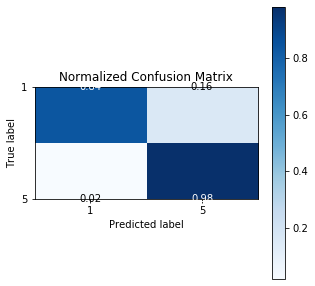

In [40]:
resultado_base = model.predict(X_test)
plt.rcParams["figure.figsize"] = (5, 5)
skplt.metrics.plot_confusion_matrix(y_test, resultado_base, normalize=True)

In [41]:
print("Acurácia: ",accuracy_score(y_test, resultado_base))
print("F1-score: ",f1_score(y_test, resultado_base, average='macro'))
print('_________________')
print(metrics.classification_report(y_test, resultado_base))

Acurácia:  0.93643339823617
F1-score:  0.9250811995714942
_________________
              precision    recall  f1-score   support

           1       0.96      0.84      0.90      8527
           5       0.93      0.98      0.95     17666

    accuracy                           0.94     26193
   macro avg       0.94      0.91      0.93     26193
weighted avg       0.94      0.94      0.94     26193



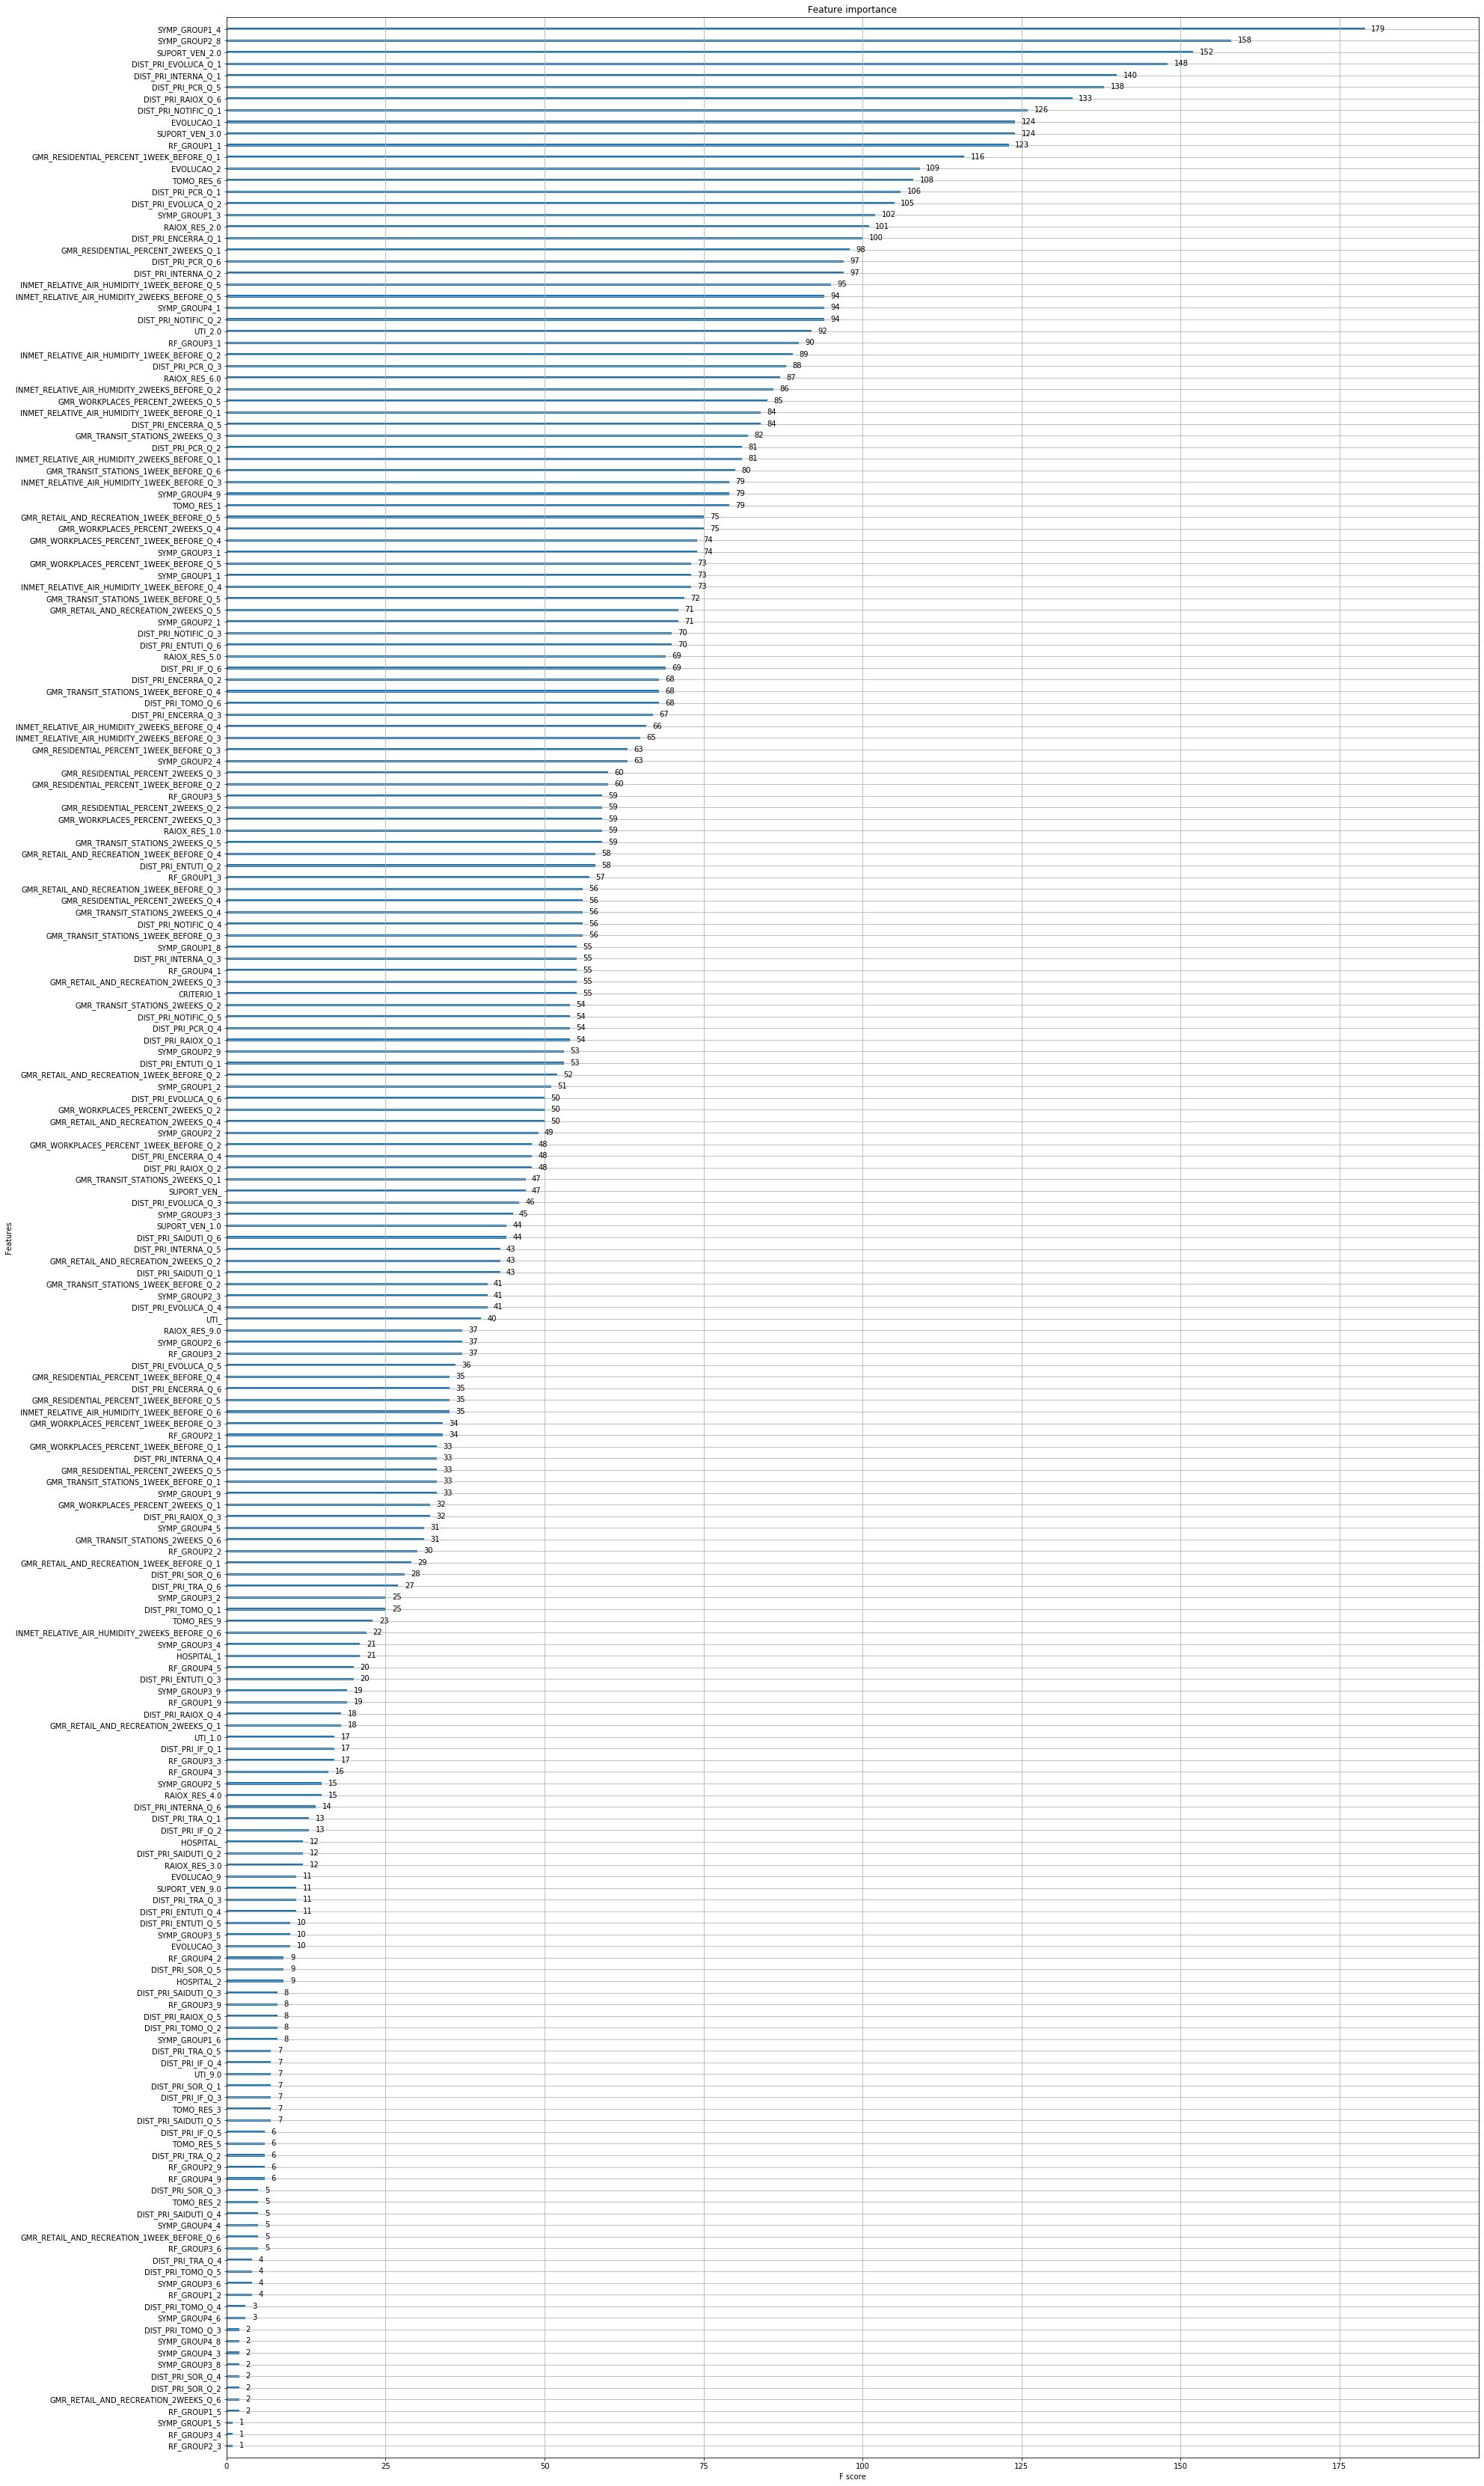

In [42]:
# importance_type can be either "weight", "gain", or "cover"
plt.rcParams["figure.figsize"] = (30, 60)
# plt.rcParams["figure.dpi"] = 300
plot_importance(model)
plt.show()

<hr />
<hr />
<hr />

### grid search

In [18]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=14,
    seed=2021
)

In [19]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]  
}
# 'booster': ['gbtree', 'gblinear', 'dart']

In [20]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 20,
    cv = 10,
    verbose=True
)

In [ ]:
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/opt/conda/anaconda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
grid_search.best_estimator_

In [ ]:
print('finished')

### running with the best estimator### 

In [43]:
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=14, nthread=14, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
 
model.fit(X_train,y_train)

/opt/conda/anaconda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:27:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=14, nthread=14, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

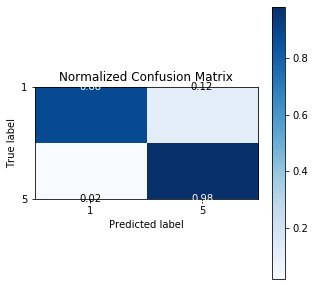

In [44]:
resultado_base = model.predict(X_test)
plt.rcParams["figure.figsize"] = (5, 5)
skplt.metrics.plot_confusion_matrix(y_test, resultado_base, normalize=True)

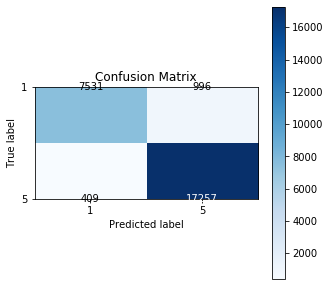

In [45]:
resultado_base = model.predict(X_test)
plt.rcParams["figure.figsize"] = (5, 5)
skplt.metrics.plot_confusion_matrix(y_test, resultado_base, normalize=False)

In [46]:
print("Acurácia: ",accuracy_score(y_test, resultado_base))
print("F1-score: ",f1_score(y_test, resultado_base, average='macro'))
print('_________________')
print(metrics.classification_report(y_test, resultado_base))

Acurácia:  0.9463597144275188
F1-score:  0.937781026114044
_________________
              precision    recall  f1-score   support

           1       0.95      0.88      0.91      8527
           5       0.95      0.98      0.96     17666

    accuracy                           0.95     26193
   macro avg       0.95      0.93      0.94     26193
weighted avg       0.95      0.95      0.95     26193



In [47]:
metrics.roc_auc_score(y_test, resultado_base)

0.930021370705829

In [48]:
metrics.confusion_matrix(y_test, resultado_base)

array([[ 7531,   996],
       [  409, 17257]])

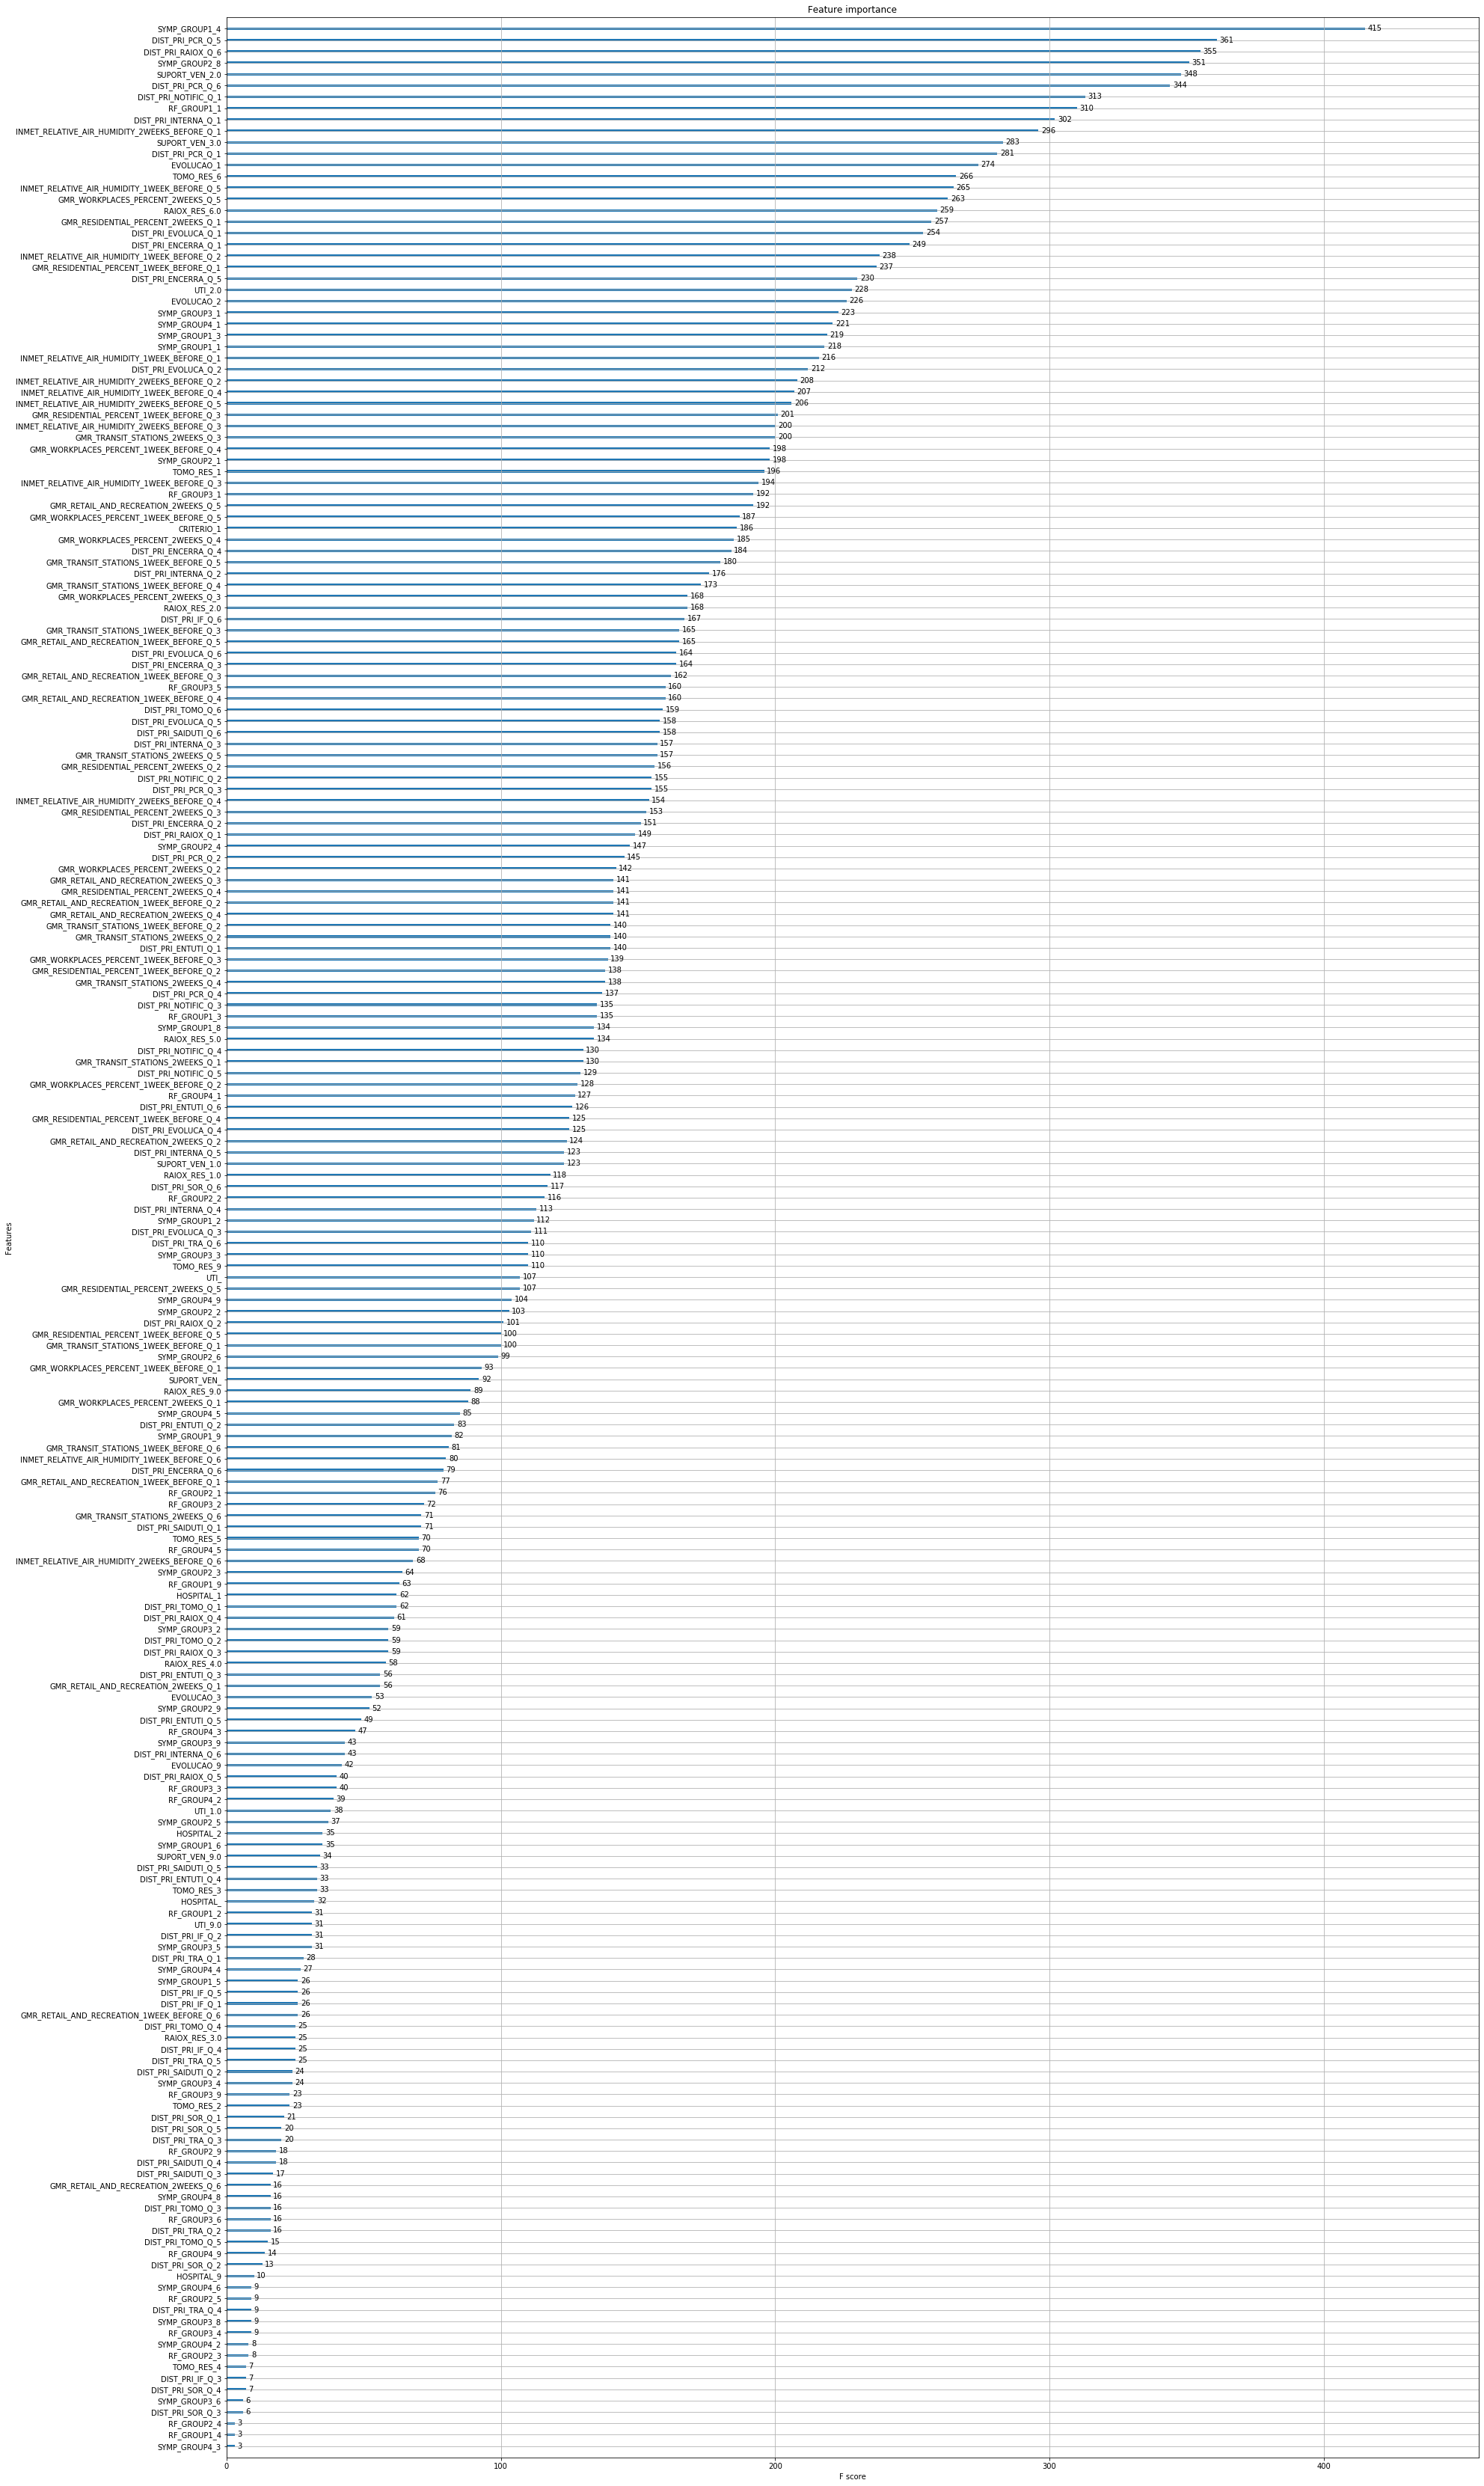

In [49]:
# importance_type can be either "weight", "gain", or "cover"
plt.rcParams["figure.figsize"] = (30, 60)
# plt.rcParams["figure.dpi"] = 300
plot_importance(model)
plt.show()